# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 20.10.2020

Мягкий дедлайн: 01:59MSK 02.11.2020 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 01:59MSK 05.11.2020

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 8.01

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). 

In [7]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

clf = make_pipeline(
        StandardScaler(), 
        SVC(kernel='linear', probability=True, random_state=42)
)

#Выделим валидационную выборку от обучающей
X_train_train, X_validation, y_train_train, y_validation = train_test_split(
    X, y, test_size=0.2, random_state=42)

#clf.get_params().keys()
searcher = GridSearchCV(clf, [{'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5]}], cv=10)
searcher.fit(X_validation, y_validation)

best_C = searcher.best_params_["svc__C"]
print("Best С = %.4f" % best_C)

clf.set_params(svc__C=best_C)
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_p = model.predict_proba(X_test)[:, 1]

Best С = 0.0500


На тестовой части посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Постройте ROC и PR кривые, сравните их с ответами случайного классификатора. Заметим, что с помощью `sklearn` можно посчитать обе метрики двумя разными способами - в чем их различия? Сравните результаты. 

Есть 2 способа расчета метрики "Precision":
- Макроусреднение - итоговая метрика расчитывается для каждого класса, затем берется среднее арифметическое для всех классов

- Микроусреднение - показатели (TP и FP) сначала усредняются по всем классам, затем на их основе считается итоговая метрика

In [8]:
from sklearn.metrics import confusion_matrix, precision_score, average_precision_score, roc_auc_score, roc_curve, precision_recall_curve

print("AUC-ROC: %.5f"%roc_auc_score(y_test, y_pred),"\n"\
"Precision_score: %.5f"%precision_score(y_test, y_pred),"\n"\
"Average precision_score: %.5f"%average_precision_score(y_test, y_pred_p))


AUC-ROC: 0.77514 
Precision_score: 0.77002 
Average precision_score: 0.81523


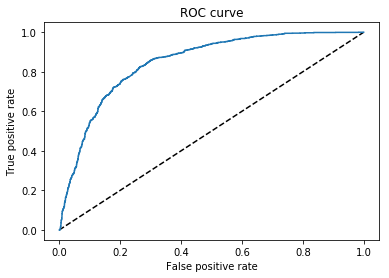

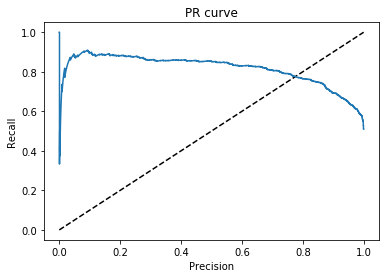

In [5]:
fp, tp, _ = roc_curve(y_test, y_pred_p)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fp, tp)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

pr, rec, _ = precision_recall_curve(y_test, y_pred_p)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rec, pr)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('PR curve')
plt.show()

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [9]:
from sklearn.linear_model import LogisticRegression

lr = make_pipeline(
        StandardScaler(), 
        LogisticRegression()
)

#clf.get_params().keys()
searcher_lr = GridSearchCV(lr, [{'logisticregression__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5]}], cv=10)
searcher_lr.fit(X_validation, y_validation)

best_C_lr = searcher_lr.best_params_["logisticregression__C"]
print("Best С = %.4f" % best_C)

lr.set_params(logisticregression__C=best_C_lr)
model_lr = lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
y_pred_p_lr = model_lr.predict_proba(X_test)[:, 1]

Best С = 0.0500


In [7]:
print("AUC-ROC: %.5f"%roc_auc_score(y_test, y_pred_lr),"\n"\
"Precision_score: %.5f"%precision_score(y_test, y_pred_lr),"\n"\
"Average precision_score: %.5f"%average_precision_score(y_test, y_pred_p_lr))

AUC-ROC: 0.77134 
Precision_score: 0.77571 
Average precision_score: 0.82940


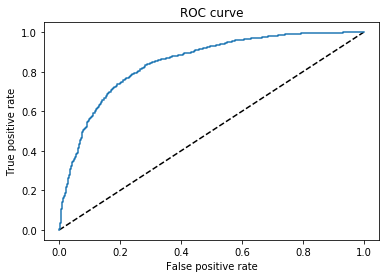

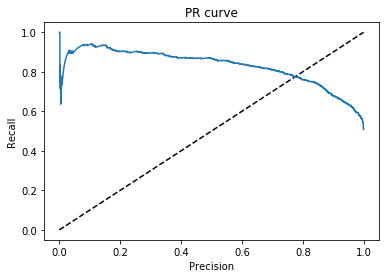

In [8]:
fp, tp, _ = roc_curve(y_test, y_pred_p_lr)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fp, tp)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

pr, rec, _ = precision_recall_curve(y_test, y_pred_p_lr)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rec, pr)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('PR curve')
plt.show()

Сравнение результатов:
- LR оказался сопоставим с линейным вариантом SVM на основе таких метрик как AUC-ROC и точность

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетический датасет с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные вектора (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [9]:
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [10]:
#Выделим валидационную выборку от обучающей
X_train_train, X_validation, y_train_train, y_validation = train_test_split(
    X, y, test_size=0.2, random_state=42)

#clf.get_params().keys()
searcher = GridSearchCV(clf, [{'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5]}], cv=10)
searcher.fit(X_validation, y_validation)

best_C = searcher.best_params_["svc__C"]
print("Best С = %.4f" % best_C)

clf.set_params(svc__C=best_C)
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_p = model.predict_proba(X_test)[:, 1]

Best С = 0.1000


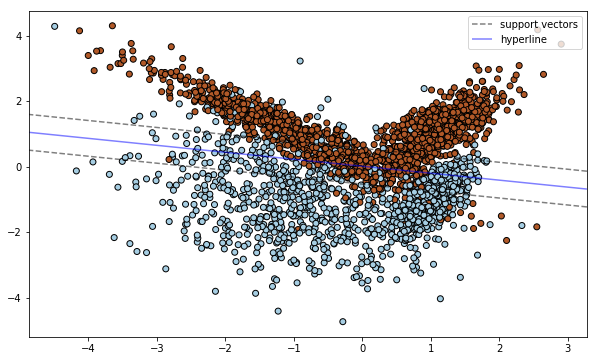

In [11]:
# часть кода для построения графиков взято с сайта https://scikit-learn.org/stable/modules/svm.html
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

plt.figure(figsize=(10, 6))

# plot the samples
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, edgecolors='k')

# plot the decision functions for both classifiers
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# get the separating hyperplane
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
a = ax.contour(XX, YY, Z, colors='k', levels=[-1], alpha=0.5, linestyles=['--'])
b = ax.contour(XX, YY, Z, colors='b', levels=[0], alpha=0.5, linestyles=['-'])
c = ax.contour(XX, YY, Z, colors='k', levels=[1], alpha=0.5, linestyles=['--'])
plt.legend([a.collections[0], b.collections[0]], ["support vectors", "hyperline"], loc="upper right")
plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость, а приближает в каждой точке пространства объектов правдоподобие положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

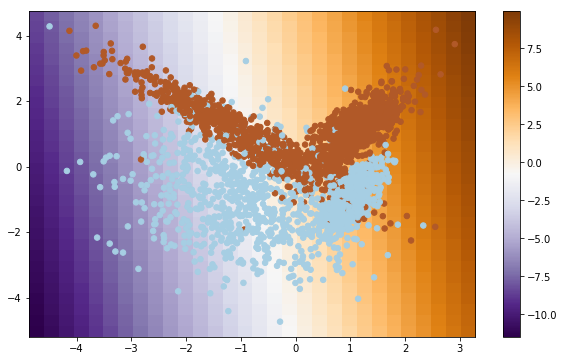

In [12]:
searcher_lr = GridSearchCV(lr, [{'logisticregression__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5]}], cv=10)
searcher_lr.fit(X_validation, y_validation)

best_C_lr = searcher_lr.best_params_["logisticregression__C"]
#print("Best С = %.4f" % best_C)

lr.set_params(logisticregression__C=best_C_lr)
model_lr = lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
y_pred_p_lr = model_lr.predict_proba(X_test)[:, 1]

plt.figure(figsize=(10, 6))

plt.scatter(X_test[:, 0], X_test[:, 1], s=30, c=y_test, cmap=plt.cm.Paired)

Z = lr.decision_function(xy).reshape(XX.shape)

image = plt.imshow(
    Z, interpolation='nearest', 
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect='auto', origin='lower', 
    cmap=plt.cm.PuOr_r
)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
plt.colorbar(image)


__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

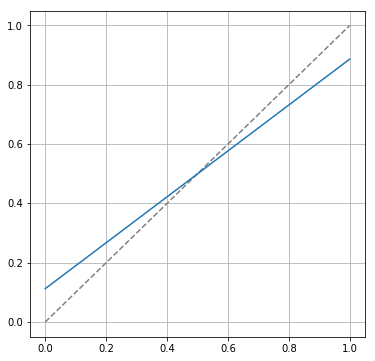

In [13]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    
    for i in range(n_bins + 1):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        true_targets = y_test[(preds >= l) & (preds < r)] == 1
        
        if np.sum(true_targets) > 0:
            #bin_middle_points.append((l + r)/2) 
            bin_middle_points.append(l) 
            bin_real_ratios.append(np.sum(true_targets)/len(true_targets))
    
    plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()
    
plot_calibration_curve(y_test, y_pred)

Сгенерируйте синтетический датасет аналогично использованному в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

Text(0.5,1,'Калибровочная кривая логистической регрессии')

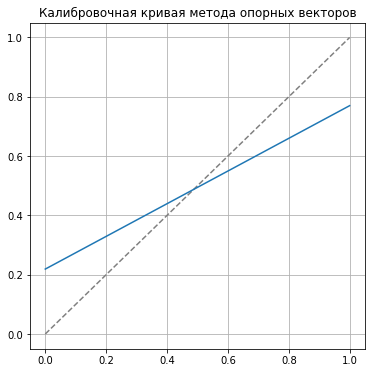

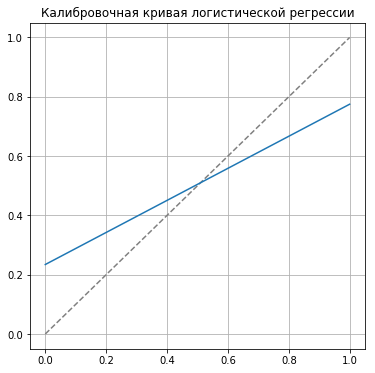

In [14]:
#your code here
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

y_pred_svm = clf.fit(X_train, y_train).predict(X_test)
y_pred_lr = lr.fit(X_train, y_train).predict(X_test)

plot_calibration_curve(y_test, y_pred_svm)
plt.title('Калибровочная кривая метода опорных векторов')
plot_calibration_curve(y_test, y_pred_lr)
plt.title('Калибровочная кривая логистической регрессии')

Text(0.5,1,'Распределение ответов классификаторов')

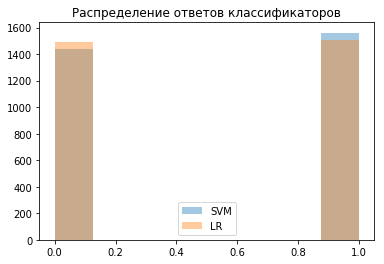

In [15]:
import seaborn as sns

sns.distplot(y_pred_svm, kde=False, label='SVM')
sns.distplot(y_pred_lr, kde=False, label='LR')
plt.legend()
plt.title('Распределение ответов классификаторов')

Text(0.5,1,'Распределение ответов классификаторов')

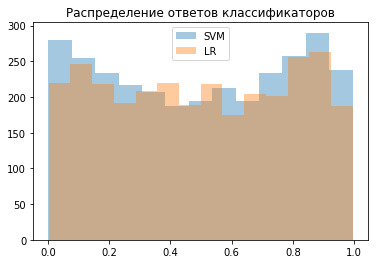

In [16]:
y_pred_p_svm = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
y_pred_p_lr = lr.fit(X_train, y_train).predict_proba(X_test)[:, 1]

sns.distplot(y_pred_p_svm, kde=False, label='SVM')
sns.distplot(y_pred_p_lr, kde=False, label='LR')
plt.legend()
plt.title('Распределение ответов классификаторов')

На калибровочных кривых различий не обнаружено

Выявлены различия в предсказании 0 и 1 каждым из методов - линейная регрессия более равномерно предсказывает каждую из вероятностей, метод опорных векторов же является более смелым алгоритмом, склоняясь к предсказанию 0 и 1, что объясняется тем, что SVM пытается максимизировать разницу между ближайшими векторами

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

Text(0.5,1,'Калибровочная кривая для SVM с использованием калибровки вероятностей')

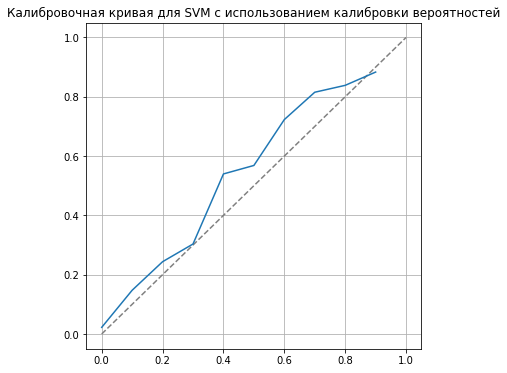

In [17]:
from sklearn.calibration import CalibratedClassifierCV

clf_calibration = CalibratedClassifierCV(clf, cv=2)
model_сс = clf_calibration.fit(X_train, y_train)
y_pred_сс = model_сс.predict(X_test)
y_pred_p_сс = model_сс.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, y_pred_p_сс)
plt.title('Калибровочная кривая для SVM с использованием калибровки вероятностей')

Мы видим, что результат значительно улучшился, т.к. калибровочная кривая стала приближена к главной диагонали

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [18]:
#your code here

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [10]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [8]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [38]:
# Отбросим duration, т.к. данный показатель может стать известен 
# лишь по окончании звонка и не сможет нам помочь для построения модели:
df = df.drop(columns = 'duration')

train, test, = train_test_split(df, stratify=df.y, test_size=0.25, random_state=777)

In [39]:
# Сбалансированная обучающая выборка
train2 = pd.concat([train[train.y=='yes'],train[train.y=='no'].sample(n=len(train[train.y=='yes']))])

In [40]:
# Сбалансированная обучающая выборка без stratify для теста
train3, test3, = train_test_split(df, test_size=0.25, random_state=777)
train3 = pd.concat([train3[train3.y=='yes'],train3[train3.y=='no'].sample(n=len(train3[train3.y=='yes']))])

In [41]:
train4, test4, = train_test_split(df, test_size=0.25, random_state=777)

In [21]:
len(train[train.y=='yes']), len(train[train.y=='no'])

(3480, 27411)

In [22]:
len(train2[train2.y=='yes']), len(train2[train2.y=='no'])

(3480, 3480)

In [23]:
len(train3[train3.y=='yes']), len(train3[train3.y=='no'])

(3475, 3475)

In [24]:
len(train4[train4.y=='yes']), len(train4[train4.y=='no'])

(3475, 27416)

In [ ]:
len(train4[train4.y=='yes']), len(train4[train4.y=='no'])

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: AUC-ROC приемлимо использовать, когда нам важна верная идентификация обоих классов, в данном же случае нам необходимо сосредоточиться на небольшом позитивном классе - клиент согласился на депозит, поэтому в качестве метрики выбрана PR

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
import time

numeric_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed']
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome'] 
target = ['y']

X_train = train[categorical+numeric_features]
y_train = train[target].replace(['yes', 'no'], [1, 0])
X_test = test[categorical+numeric_features]
y_test = test[target].replace(['yes', 'no'], [1, 0])

# Замерим время обучения модели
start_time = time.time()

column_transformer = ColumnTransformer([
# OrdinalEncoder кодирование для категориальных признаков
    ('ohe', OrdinalEncoder(), categorical), 
# Масштабирование для числовых
    ('scaling', StandardScaler(), numeric_features) 
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(C=0.2))
])

model = pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

print("--- %s seconds for LR ---" % (time.time() - start_time))

# Расчитаем precision 2мя способами, однако при сравнении будем ориентироваться на average_precision_score:
print("Precision_score: %.5f"%precision_score(y_test, y_pred),"\n"\
"Roc_auc_score: %.5f"%roc_auc_score(y_test, y_pred_prob))


--- 0.625694990158081 seconds for LR ---
Precision_score: 0.70081 
Roc_auc_score: 0.78836


In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
import time

numeric_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed']
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome'] 
target = ['y']

X_train = train2[categorical+numeric_features]
y_train = train2[target].replace(['yes', 'no'], [1, 0])
X_test = test[categorical+numeric_features]
y_test = test[target].replace(['yes', 'no'], [1, 0])

# Замерим время обучения модели
start_time = time.time()

column_transformer = ColumnTransformer([
# OrdinalEncoder кодирование для категориальных признаков
    ('ohe', OrdinalEncoder(), categorical), 
# Масштабирование для числовых
    ('scaling', StandardScaler(), numeric_features) 
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(C=0.2))
])

model = pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

print("--- %s seconds for LR ---" % (time.time() - start_time))

# Расчитаем precision 2мя способами, однако при сравнении будем ориентироваться на average_precision_score:
print("Precision_score: %.5f"%precision_score(y_test, y_pred),"\n"\
"Roc_auc_score: %.5f"%roc_auc_score(y_test, y_pred_prob))


--- 0.584975004196167 seconds for LR ---
Precision_score: 0.30766 
Roc_auc_score: 0.78729


In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
import time

numeric_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed']
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome'] 
target = ['y']

X_train = train3[categorical+numeric_features]
y_train = train3[target].replace(['yes', 'no'], [1, 0])
X_test = test3[categorical+numeric_features]
y_test = test3[target].replace(['yes', 'no'], [1, 0])

# Замерим время обучения модели
start_time = time.time()

column_transformer = ColumnTransformer([
# OrdinalEncoder кодирование для категориальных признаков
    ('ohe', OrdinalEncoder(), categorical), 
# Масштабирование для числовых
    ('scaling', StandardScaler(), numeric_features) 
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(C=0.2))
])

model = pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

print("--- %s seconds for LR ---" % (time.time() - start_time))

# Расчитаем precision 2мя способами, однако при сравнении будем ориентироваться на average_precision_score:
print("Precision_score: %.5f"%precision_score(y_test, y_pred),"\n"\
"Roc_auc_score: %.5f"%roc_auc_score(y_test, y_pred_prob))


--- 0.3663489818572998 seconds for LR ---
Precision_score: 0.32060 
Roc_auc_score: 0.79675


In [86]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

numeric_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed']
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome'] 
target = ['y']

column_transformer = ColumnTransformer([
# OrdinalEncoder кодирование для категориальных признаков
    ('ohe', OrdinalEncoder(), categorical), 
# Масштабирование для числовых
    ('scaling', StandardScaler(), numeric_features) 
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', RandomForestClassifier())
])

X_train = train[categorical+numeric_features]
y_train = train[target].replace(['yes', 'no'], [1, 0])
X_test = test[categorical+numeric_features]
y_test = test[target].replace(['yes', 'no'], [1, 0])
y_pred = pipeline.fit(X_train, y_train).predict_proba(X_test)[:, 1]
print("Roc_auc_score: %.5f"%roc_auc_score(y_test, y_pred))
print("precision_score: %.5f"%precision_score(y_test, np.int8(y_pred+0.5)))

X_train = train2[categorical+numeric_features]
y_train = train2[target].replace(['yes', 'no'], [1, 0])
X_test = test[categorical+numeric_features]
y_test = test[target].replace(['yes', 'no'], [1, 0])
y_pred = pipeline.fit(X_train, y_train).predict_proba(X_test)[:, 1]
print("Roc_auc_score: %.5f"%roc_auc_score(y_test, y_pred))
print("precision_score: %.5f"%precision_score(y_test, np.int8(y_pred+0.5)))

X_train = train3[categorical+numeric_features]
y_train = train3[target].replace(['yes', 'no'], [1, 0])
X_test = test3[categorical+numeric_features]
y_test = test3[target].replace(['yes', 'no'], [1, 0])
y_pred = pipeline.fit(X_train, y_train).predict_proba(X_test)[:, 1]
print("Roc_auc_score: %.5f"%roc_auc_score(y_test, y_pred))
print("precision_score: %.5f"%precision_score(y_test, np.int8(y_pred+0.5)))

X_train = train4[categorical+numeric_features]
y_train = train4[target].replace(['yes', 'no'], [1, 0])
X_test = test4[categorical+numeric_features]
y_test = test4[target].replace(['yes', 'no'], [1, 0])
y_pred = pipeline.fit(X_train, y_train).predict_proba(X_test)[:, 1]
print("Roc_auc_score: %.5f"%roc_auc_score(y_test, y_pred))
print("precision_score: %.5f"%precision_score(y_test, np.int8(y_pred+0.5)))

Roc_auc_score: 0.77555
precision_score: 0.54559
Roc_auc_score: 0.78893
precision_score: 0.29231
Roc_auc_score: 0.77657
precision_score: 0.31392
Roc_auc_score: 0.76586
precision_score: 0.56250


In [87]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(C=0.2))
])

X_train = train[categorical+numeric_features]
y_train = train[target].replace(['yes', 'no'], [1, 0])
X_test = test[categorical+numeric_features]
y_test = test[target].replace(['yes', 'no'], [1, 0])
y_pred = pipeline.fit(X_train, y_train).predict_proba(X_test)[:, 1]
print("Roc_auc_score: %.5f"%roc_auc_score(y_test, y_pred))
print("precision_score: %.5f"%precision_score(y_test, np.int8(y_pred+0.5)))

X_train = train2[categorical+numeric_features]
y_train = train2[target].replace(['yes', 'no'], [1, 0])
X_test = test[categorical+numeric_features]
y_test = test[target].replace(['yes', 'no'], [1, 0])
y_pred = pipeline.fit(X_train, y_train).predict_proba(X_test)[:, 1]
print("Roc_auc_score: %.5f"%roc_auc_score(y_test, y_pred))
print("precision_score: %.5f"%precision_score(y_test, np.int8(y_pred+0.5)))

X_train = train3[categorical+numeric_features]
y_train = train3[target].replace(['yes', 'no'], [1, 0])
X_test = test3[categorical+numeric_features]
y_test = test3[target].replace(['yes', 'no'], [1, 0])
y_pred = pipeline.fit(X_train, y_train).predict_proba(X_test)[:, 1]
print("Roc_auc_score: %.5f"%roc_auc_score(y_test, y_pred))
print("precision_score: %.5f"%precision_score(y_test, np.int8(y_pred+0.5)))

X_train = train4[categorical+numeric_features]
y_train = train4[target].replace(['yes', 'no'], [1, 0])
X_test = test4[categorical+numeric_features]
y_test = test4[target].replace(['yes', 'no'], [1, 0])
y_pred = pipeline.fit(X_train, y_train).predict_proba(X_test)[:, 1]
print("Roc_auc_score: %.5f"%roc_auc_score(y_test, y_pred))
print("precision_score: %.5f"%precision_score(y_test, np.int8(y_pred+0.5)))

Roc_auc_score: 0.78428
precision_score: 0.66752
Roc_auc_score: 0.78439
precision_score: 0.29459
Roc_auc_score: 0.77965
precision_score: 0.31257
Roc_auc_score: 0.77755
precision_score: 0.70219


In [88]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', CatBoostClassifier(iterations=100, verbose=False))
])

X_train = train[categorical+numeric_features]
y_train = train[target].replace(['yes', 'no'], [1, 0])
X_test = test[categorical+numeric_features]
y_test = test[target].replace(['yes', 'no'], [1, 0])
y_pred = pipeline.fit(X_train, y_train).predict_proba(X_test)[:, 1]
print("Roc_auc_score: %.5f"%roc_auc_score(y_test, y_pred))
print("precision_score: %.5f"%precision_score(y_test, np.int8(y_pred+0.5)))

X_train = train2[categorical+numeric_features]
y_train = train2[target].replace(['yes', 'no'], [1, 0])
X_test = test[categorical+numeric_features]
y_test = test[target].replace(['yes', 'no'], [1, 0])
y_pred = pipeline.fit(X_train, y_train).predict_proba(X_test)[:, 1]
print("Roc_auc_score: %.5f"%roc_auc_score(y_test, y_pred))
print("precision_score: %.5f"%precision_score(y_test, np.int8(y_pred+0.5)))

X_train = train3[categorical+numeric_features]
y_train = train3[target].replace(['yes', 'no'], [1, 0])
X_test = test3[categorical+numeric_features]
y_test = test3[target].replace(['yes', 'no'], [1, 0])
y_pred = pipeline.fit(X_train, y_train).predict_proba(X_test)[:, 1]
print("Roc_auc_score: %.5f"%roc_auc_score(y_test, y_pred))
print("precision_score: %.5f"%precision_score(y_test, np.int8(y_pred+0.5)))

X_train = train4[categorical+numeric_features]
y_train = train4[target].replace(['yes', 'no'], [1, 0])
X_test = test4[categorical+numeric_features]
y_test = test4[target].replace(['yes', 'no'], [1, 0])
y_pred = pipeline.fit(X_train, y_train).predict_proba(X_test)[:, 1]
print("Roc_auc_score: %.5f"%roc_auc_score(y_test, y_pred))
print("precision_score: %.5f"%precision_score(y_test, np.int8(y_pred+0.5)))

Roc_auc_score: 0.80079
precision_score: 0.63796
Roc_auc_score: 0.80140
precision_score: 0.35493
Roc_auc_score: 0.79543
precision_score: 0.37048
Roc_auc_score: 0.79840
precision_score: 0.64496


Построим матрицу ошибок и precision_recall_curve для понимания результатов

In [23]:
#        Predicted
# Actual TN FP
#        FN TP
confusion_matrix(y_test, y_pred)/len(y_test)

array([[0.87472079, 0.01262504],
       [0.0874041 , 0.02525007]])

Пока наблюдаем большие проблемы с предсказанием позитивного класса

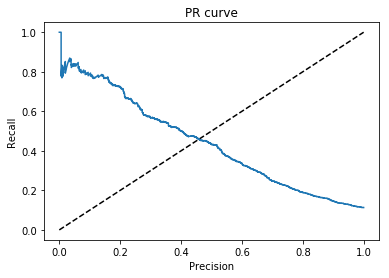

In [24]:
pr, rec, _ = precision_recall_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rec, pr)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('PR curve')
plt.show()

__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [25]:
from sklearn.preprocessing import OneHotEncoder

# Замерим время обучения модели
start_time = time.time()

column_transformer = ColumnTransformer([
# OrdinalEncoder кодирование для категориальных признаков
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical), 
# Масштабирование для числовых
    ('scaling', StandardScaler(), numeric_features) 
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(C=0.2))
])

model = pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

print("--- %s seconds for LR ---" % (time.time() - start_time))

print("Precision_score: %.5f"%precision_score(y_test, y_pred),"\n"\
"Average precision_score: %.5f"%average_precision_score(y_test, y_pred_prob))

--- 0.8932838439941406 seconds for LR ---
Precision_score: 0.67470 
Average precision_score: 0.45033


Наблюдаем небольшое улучшение качества работы модели (на основе average_precision_score), а также увеличение времени работы

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 


In [26]:
df['y'] = df.y.replace(['yes', 'no'], [1, 0])

df['true_target_ratio_job'] =\
    df[['job','y']].groupby(by=['job']).y.transform(lambda s: np.mean(s.values))
df['true_target_ratio_marital'] =\
    df[['marital','y']].groupby(by=['marital']).y.transform(lambda s: np.mean(s.values))
df['true_target_ratio_education'] =\
    df[['education','y']].groupby(by=['education']).y.transform(lambda s: np.mean(s.values))
df['true_target_ratio_default'] =\
    df[['default','y']].groupby(by=['default']).y.transform(lambda s: np.mean(s.values))
df['true_target_ratio_housing'] =\
    df[['housing','y']].groupby(by=['housing']).y.transform(lambda s: np.mean(s.values))
df['true_target_ratio_loan'] =\
    df[['loan','y']].groupby(by=['loan']).y.transform(lambda s: np.mean(s.values))
df['true_target_ratio_contact'] =\
    df[['contact','y']].groupby(by=['contact']).y.transform(lambda s: np.mean(s.values))
df['true_target_ratio_month'] =\
    df[['month','y']].groupby(by=['month']).y.transform(lambda s: np.mean(s.values))
df['true_target_ratio_day_of_week'] =\
    df[['day_of_week','y']].groupby(by=['day_of_week']).y.transform(lambda s: np.mean(s.values))
df['true_target_ratio_poutcome'] =\
    df[['poutcome','y']].groupby(by=['poutcome']).y.transform(lambda s: np.mean(s.values))

In [27]:
train, test, = train_test_split(df, stratify=df.y, test_size=0.25, random_state=777)

new_features = ['true_target_ratio_job','true_target_ratio_marital','true_target_ratio_education',
                'true_target_ratio_default','true_target_ratio_housing','true_target_ratio_loan',
                'true_target_ratio_contact','true_target_ratio_month','true_target_ratio_day_of_week',
                'true_target_ratio_poutcome']
numeric_features += new_features

X_train = train[numeric_features]
y_train = train[target]
X_test = test[numeric_features]
y_test = test[target]

# Замерим время обучения модели
start_time = time.time()

column_transformer = ColumnTransformer([
# OrdinalEncoder кодирование для категориальных признаков
#    ('ohe', OrdinalEncoder(), categorical), 
# Масштабирование для числовых
    ('scaling', StandardScaler(), numeric_features) 
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(C=0.2))
])

model = pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

print("--- %s seconds for LR ---" % (time.time() - start_time))

print("Precision_score: %.5f"%precision_score(y_test, y_pred),"\n"\
"Average precision_score: %.5f"%average_precision_score(y_test, y_pred_prob))

--- 0.2442018985748291 seconds for LR ---
Precision_score: 0.64719 
Average precision_score: 0.44341


За счет применения счетчиков качество модели в ходе переобучения упало, однако скорость значительно возросла

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [28]:
#Добавим шума в данные
df[new_features] = df[new_features] + np.random.normal(0, 0.05, df[new_features].shape) 

train, test, = train_test_split(df, stratify=df.y, test_size=0.25, random_state=777)

X_train = train[numeric_features]
y_train = train[target]
X_test = test[numeric_features]
y_test = test[target]

# Замерим время обучения модели
start_time = time.time()

column_transformer = ColumnTransformer([
# OrdinalEncoder кодирование для категориальных признаков
#    ('ohe', OrdinalEncoder(), categorical), 
# Масштабирование для числовых
    ('scaling', StandardScaler(), numeric_features) 
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(C=0.2))
])

model = pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

print("--- %s seconds for LR ---" % (time.time() - start_time))

print("Precision_score: %.5f"%precision_score(y_test, y_pred),"\n"\
"Average precision_score: %.5f"%average_precision_score(y_test, y_pred_prob))

--- 0.1656649112701416 seconds for LR ---
Precision_score: 0.65274 
Average precision_score: 0.43540


К сожалению, поднять Average_precision_score при различных настройках добавления шума нам не удалось

__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



In [29]:
#your code here

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [30]:
C = 100
global_mean = 0.1
new_features = []

# Новым колонкам со сглаживанием перед наименованием признака добавим 'new_':
for column_name in categorical:
    
    df['new_'+column_name] = df[[column_name,'y']].groupby(by=[column_name]).y.transform(
        lambda s: (np.count_nonzero(s.values)+C*global_mean)/(len(s.values)+C)
    )
    new_features.append('new_'+column_name)
    
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,true_target_ratio_job,true_target_ratio_marital,true_target_ratio_education,true_target_ratio_default,true_target_ratio_housing,true_target_ratio_loan,true_target_ratio_contact,true_target_ratio_month,true_target_ratio_day_of_week,true_target_ratio_poutcome,new_job,new_marital,new_education,new_default,new_housing,new_loan,new_contact,new_month,new_day_of_week,new_poutcome
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0.099811,0.021388,0.033964,0.139058,0.131783,0.107449,0.117378,0.057513,0.049958,0.095798,0.100000,0.101566,0.102432,0.128702,0.108749,0.113363,0.052628,0.064605,0.099489,0.088355
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0.083921,0.057826,0.106124,0.021475,0.055539,0.157056,0.159373,0.053385,0.059159,0.077700,0.081838,0.101566,0.108268,0.052087,0.108749,0.113363,0.052628,0.064605,0.099489,0.088355
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0.175976,0.077966,0.143045,0.113839,0.106704,0.153772,0.202728,0.019067,0.086066,0.065058,0.081838,0.101566,0.108268,0.128702,0.116119,0.113363,0.052628,0.064605,0.099489,0.088355
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0.101728,0.048787,0.064471,0.096063,0.162179,0.053730,-0.001584,-0.001945,0.181966,0.075511,0.129443,0.101566,0.082776,0.128702,0.108749,0.113363,0.052628,0.064605,0.099489,0.088355
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0.175058,0.105624,0.108096,0.173765,0.023930,0.131721,-0.032631,0.026918,0.165553,0.214789,0.081838,0.101566,0.108268,0.128702,0.108749,0.109168,0.052628,0.064605,0.099489,0.088355


In [31]:
train, test, = train_test_split(df, stratify=df.y, test_size=0.25, random_state=777)

old_numeric_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed']
numeric_features = old_numeric_features + new_features

X_train = train[numeric_features]
y_train = train[target]
X_test = test[numeric_features]
y_test = test[target]

# Замерим время обучения модели
start_time = time.time()

column_transformer = ColumnTransformer([
# OrdinalEncoder кодирование для категориальных признаков
#    ('ohe', OrdinalEncoder(), categorical), 
# Масштабирование для числовых
    ('scaling', StandardScaler(), numeric_features) 
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(C=0.2))
])

model = pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

print("--- %s seconds for LR ---" % (time.time() - start_time))

print("Precision_score: %.5f"%precision_score(y_test, y_pred),"\n"\
"Average precision_score: %.5f"%average_precision_score(y_test, y_pred_prob))

--- 0.20206165313720703 seconds for LR ---
Precision_score: 0.64944 
Average precision_score: 0.44277


На экспериментах без шума значимых улучшений обнаружено не было

Повторим эксперимент с добавлением шума в новые признаки:

In [32]:
#Добавим шума в данные
df[new_features] = df[new_features] + np.random.normal(0, 0.05, df[new_features].shape) 

train, test, = train_test_split(df, stratify=df.y, test_size=0.25, random_state=777)

X_train = train[numeric_features]
y_train = train[target]
X_test = test[numeric_features]
y_test = test[target]

# Замерим время обучения модели
start_time = time.time()

column_transformer = ColumnTransformer([
# OrdinalEncoder кодирование для категориальных признаков
#    ('ohe', OrdinalEncoder(), categorical), 
# Масштабирование для числовых
    ('scaling', StandardScaler(), numeric_features) 
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(C=0.2))
])

model = pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

print("--- %s seconds for LR ---" % (time.time() - start_time))

print("Precision_score: %.5f"%precision_score(y_test, y_pred),"\n"\
"Average precision_score: %.5f"%average_precision_score(y_test, y_pred_prob))

--- 0.14340877532958984 seconds for LR ---
Precision_score: 0.68074 
Average precision_score: 0.43326


К сожалению, поднять average_precision_score при различных настройках добавления шума нам не удалось

__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [33]:
print(len(df.age.unique()))
df.age.unique()

78


array([56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 54, 46, 50, 39, 30, 55,
       49, 34, 52, 58, 32, 38, 44, 42, 60, 53, 47, 51, 48, 33, 31, 43, 36,
       28, 27, 26, 22, 23, 20, 21, 61, 19, 18, 70, 66, 76, 67, 73, 88, 95,
       77, 68, 75, 63, 80, 62, 65, 72, 82, 64, 71, 69, 78, 85, 79, 83, 81,
       74, 17, 87, 91, 86, 98, 94, 84, 92, 89])

Воспользуемся счетчиками с добавлением шума, т.к. данный подход пока показал лучший результат

In [34]:
df['new_age'] = df[['age','y']].groupby(by=['age']).y.transform(lambda s: np.mean(s.values)) + \
                np.random.normal(0, 0.1, df[new_features].shape[0])

train, test, = train_test_split(df, stratify=df.y, test_size=0.25, random_state=777)

numeric_features.remove('age')
numeric_features.append('new_age')

X_train = train[numeric_features]
y_train = train[target]
X_test = test[numeric_features]
y_test = test[target]

# Замерим время обучения модели
start_time = time.time()

column_transformer = ColumnTransformer([
# OrdinalEncoder кодирование для категориальных признаков
#    ('ohe', OrdinalEncoder(), categorical), 
# Масштабирование для числовых
    ('scaling', StandardScaler(), numeric_features) 
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(C=0.2))
])

model = pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

print("--- %s seconds for LR ---" % (time.time() - start_time))

print("Precision_score: %.5f"%precision_score(y_test, y_pred),"\n"\
"Average precision_score: %.5f"%average_precision_score(y_test, y_pred_prob))

--- 0.17034602165222168 seconds for LR ---
Precision_score: 0.67179 
Average precision_score: 0.43350


Значимых улучшений не обнаружено

Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [35]:
df['month_num'] = df.month.replace(['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], range(10))
df['day_of_week_num'] = df.day_of_week.replace(['mon', 'tue', 'wed', 'thu', 'fri'], range(5))
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,true_target_ratio_job,true_target_ratio_marital,true_target_ratio_education,true_target_ratio_default,true_target_ratio_housing,true_target_ratio_loan,true_target_ratio_contact,true_target_ratio_month,true_target_ratio_day_of_week,true_target_ratio_poutcome,new_job,new_marital,new_education,new_default,new_housing,new_loan,new_contact,new_month,new_day_of_week,new_poutcome,new_age,month_num,day_of_week_num
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0.099811,0.021388,0.033964,0.139058,0.131783,0.107449,0.117378,0.057513,0.049958,0.095798,0.072283,0.110396,0.124692,0.202614,0.042274,0.200836,0.018484,-0.019424,0.088621,0.047811,0.099264,2,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0.083921,0.057826,0.106124,0.021475,0.055539,0.157056,0.159373,0.053385,0.059159,0.077700,0.124100,0.034914,0.099743,0.040097,0.019407,0.149972,0.075697,0.029034,0.086899,0.009767,-0.023009,2,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0.175976,0.077966,0.143045,0.113839,0.106704,0.153772,0.202728,0.019067,0.086066,0.065058,0.099296,0.119861,0.180122,0.057734,0.184193,0.205171,-0.028378,0.046762,0.194609,0.074540,0.165493,2,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0.101728,0.048787,0.064471,0.096063,0.162179,0.053730,-0.001584,-0.001945,0.181966,0.075511,0.068559,0.139480,0.116549,0.048990,0.120929,0.085127,0.060853,0.032924,0.083844,0.057076,-0.040286,2,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0.175058,0.105624,0.108096,0.173765,0.023930,0.131721,-0.032631,0.026918,0.165553,0.214789,0.163846,0.100886,0.099976,0.121110,0.059476,0.060207,0.017844,0.052702,0.164863,0.085149,0.118925,2,0


In [36]:
train, test, = train_test_split(df, stratify=df.y, test_size=0.25, random_state=777)

#Удалим переменные-счетчики для месяца и дня недели из наших признаков
numeric_features.remove('new_month')
numeric_features.remove('new_day_of_week')

#И добавим новые переменные - уже числовые
numeric_features.append('month_num')
numeric_features.append('day_of_week_num')

X_train = train[numeric_features]
y_train = train[target]
X_test = test[numeric_features]
y_test = test[target]

# Замерим время обучения модели
start_time = time.time()

column_transformer = ColumnTransformer([
# OrdinalEncoder кодирование для категориальных признаков
#    ('ohe', OrdinalEncoder(), categorical), 
# Масштабирование для числовых
    ('scaling', StandardScaler(), numeric_features) 
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(C=0.2))
])

model = pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

print("--- %s seconds for LR ---" % (time.time() - start_time))

print("Precision_score: %.5f"%precision_score(y_test, y_pred),"\n"\
"Average precision_score: %.5f"%average_precision_score(y_test, y_pred_prob))

--- 0.21314120292663574 seconds for LR ---
Precision_score: 0.67116 
Average precision_score: 0.42574


__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__  
- Из основных плюсов является, прежде всего, значительное увеличение скорости работы алгоритма за счет меньшего числа признаков (по сравнению с one-hot-кодированием)

- К минусам можно отнести риск переобучения, который однако можно нивелировать добавлением шума в данные

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про банковский телефонный маркетинг.

In [37]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [38]:
numeric_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed']
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome'] 

print('Число категориальных признаков до кодирования:',len(categorical))

print('Число категориальных признаков после кодирования:',pd.DataFrame(OneHotEncoder(sparse=False).fit_transform(df[categorical])).shape[1])
      

Число категориальных признаков до кодирования: 10
Число категориальных признаков после кодирования: 53


Количество признаков увеличилось на 43

In [39]:
X = X.join(pd.DataFrame(OneHotEncoder(sparse=False).fit_transform(df[categorical])))
X = X.drop(columns=categorical)
X.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

start_time = time.time()

pipeline = Pipeline(steps=[
    ('regression', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

print("--- %s seconds for LR ---" % (time.time() - start_time))

print("Precision_score: %.5f"%precision_score(y_test, y_pred),"\n"\
"Average precision_score: %.5f"%average_precision_score(y_test, y_pred_prob))

--- 0.7596259117126465 seconds for LR ---
Precision_score: 0.67667 
Average precision_score: 0.43014


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [41]:
info_df = pd.DataFrame([])
info_df['coef'] = np.reshape(model[0].coef_, model[0].coef_.shape[1])
info_df['abs_coef'] = np.reshape(abs(model[0].coef_), model[0].coef_.shape[1])
info_df['columns'] = X.columns

significant_columns = info_df.nlargest(40, 'abs_coef')['columns']
print("40 отобранных признаков:", list(significant_columns))

X_train, X_test, y_train, y_test = train_test_split(X[significant_columns], y, test_size=0.2, random_state=777, stratify=y)

start_time = time.time()

pipeline = Pipeline(steps=[
    ('regression', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

print("--- %s seconds for LR ---" % (time.time() - start_time))

print("Precision_score: %.5f"%precision_score(y_test, y_pred),"\n"\
"Average precision_score: %.5f"%average_precision_score(y_test, y_pred_prob))


40 отобранных признаков: ['cons.price.idx', 41, 'euribor3m', 'emp.var.rate', 33, 34, 38, 50, 1, 51, 'previous', 22, 24, 25, 46, 14, 40, 13, 18, 0, 39, 5, 35, 49, 47, 'cons.conf.idx', 8, 7, 36, 42, 16, 30, 19, 43, 9, 'campaign', 48, 27, 17, 23]
--- 0.4910140037536621 seconds for LR ---
Precision_score: 0.66773 
Average precision_score: 0.43909


Качество модели значительно не изменилось

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [42]:
# Заменим числовые признаки в X на отмасштабированные:
X[numeric_features] = pd.DataFrame(StandardScaler().fit_transform(X[numeric_features]))
# Пересоберем train и test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

# Отберем 40 признаков с наибольшим весом:
new_coef = pipeline.fit(X_train, y_train)[0].coef_
info_df = pd.DataFrame([])
info_df['coef'] = np.reshape(new_coef, new_coef.shape[1])
info_df['abs_coef'] = np.reshape(abs(new_coef), new_coef.shape[1])
info_df['columns'] = X.columns

significant_columns = info_df.nlargest(40, 'abs_coef')['columns']
print("40 отобранных признаков:", list(significant_columns))

X_train, X_test, y_train, y_test = train_test_split(X[significant_columns], y, test_size=0.2, random_state=777, stratify=y)

start_time = time.time()

pipeline = Pipeline(steps=[
    ('regression', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

print("--- %s seconds for LR ---" % (time.time() - start_time))

print("Precision_score: %.5f"%precision_score(y_test, y_pred),"\n"\
"Average precision_score: %.5f"%average_precision_score(y_test, y_pred_prob))


40 отобранных признаков: ['emp.var.rate', 40, 'cons.price.idx', 39, 34, 41, 42, 50, 'nr.employed', 46, 25, 36, 5, 37, 'pdays', 'euribor3m', 1, 28, 31, 13, 12, 32, 35, 29, 16, 8, 14, 43, 27, 10, 'cons.conf.idx', 24, 30, 'campaign', 7, 21, 3, 18, 19, 4]
--- 0.9796881675720215 seconds for LR ---
Precision_score: 0.64655 
Average precision_score: 0.44863


Качество модели (на основе average precision_score) увеличилось

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [43]:
# Заменим признаки в X на отмасштабированные:
X = pd.DataFrame(StandardScaler().fit_transform(X))
# Пересоберем train и test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

# Отберем 40 признаков с наибольшим весом:
new_coef = pipeline.fit(X_train, y_train)[0].coef_
info_df = pd.DataFrame([])
info_df['coef'] = np.reshape(new_coef, new_coef.shape[1])
info_df['abs_coef'] = np.reshape(abs(new_coef), new_coef.shape[1])
info_df['columns'] = X.columns

significant_columns = info_df.nlargest(40, 'abs_coef')['columns']
print("40 отобранных признаков:", list(significant_columns))

X_train, X_test, y_train, y_test = train_test_split(X[significant_columns], y, test_size=0.2, random_state=777, stratify=y)

start_time = time.time()

pipeline = Pipeline(steps=[
    ('regression', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

print("--- %s seconds for LR ---" % (time.time() - start_time))

print("Precision_score: %.5f"%precision_score(y_test, y_pred),"\n"\
"Average precision_score: %.5f"%average_precision_score(y_test, y_pred_prob))


40 отобранных признаков: [4, 5, 8, 7, 2, 45, 49, 48, 42, 43, 6, 50, 1, 35, 55, 59, 51, 47, 14, 10, 58, 61, 60, 53, 33, 34, 3, 46, 17, 56, 31, 44, 25, 9, 52, 18, 26, 16, 57, 39]
--- 1.0924861431121826 seconds for LR ---
Precision_score: 0.65418 
Average precision_score: 0.44882


Список изменился - новые признаки вытеснили прежние числовые

Качество модели значимо не изменилось

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [44]:
# Вернем Х до масштабирования признаков:
X = df.drop(columns=['duration'])
X = X.join(pd.DataFrame(OneHotEncoder(sparse=False).fit_transform(df[categorical])))
X = X.drop(columns=categorical)
X.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [45]:
start_time = time.time()

mean_df = pd.DataFrame([])
std_df = pd.DataFrame([])
count_df = pd.DataFrame([])

mean_df = X.groupby(by=['y'], as_index=False).mean()
std_df = X.groupby(by=['y'], as_index=False).std()
count_df = X.groupby(by=['y'], as_index=False).count()

X = X.drop(columns=['y'])

filter_df = pd.DataFrame([])
l = []

for column_name in X.columns:
    l.append(\
        abs(mean_df[mean_df.y=='yes'][column_name].values[0] - mean_df[mean_df.y=='no'][column_name].values[0])/\
        np.sqrt(
            (count_df[count_df.y=='yes'][column_name].values[0] * (std_df[std_df.y=='yes'][column_name].values[0])**2 + 
             count_df[count_df.y=='no'][column_name].values[0] * (std_df[std_df.y=='no'][column_name].values[0])**2 
            )/\
            (count_df[count_df.y=='yes'][column_name].values[0] + count_df[count_df.y=='no'][column_name].values[0])
        )
   )
        
filter_df['t'] = l
filter_df['column_name'] = X.columns

significant_columns = filter_df.nlargest(40, 't')['column_name']
print("--- %s seconds for Feature Selection ---" % (time.time() - start_time))
print("40 отобранных признаков:", list(significant_columns))


--- 1.2316977977752686 seconds for Feature Selection ---
40 отобранных признаков: ['nr.employed', 'pdays', 52, 'euribor3m', 'emp.var.rate', 'previous', 51, 33, 34, 40, 43, 'cons.price.idx', 44, 41, 24, 25, 8, 5, 37, 35, 1, 'campaign', 'cons.conf.idx', 14, 22, 18, 13, 7, 38, 50, 0, 'age', 17, 23, 46, 2, 10, 47, 42, 29]


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X[significant_columns], y, test_size=0.2, random_state=777, stratify=y)

start_time = time.time()

pipeline = Pipeline(steps=[
    ('regression', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

print("--- %s seconds for LR ---" % (time.time() - start_time))

print("Precision_score: %.5f"%precision_score(y_test, y_pred),"\n"\
"Average precision_score: %.5f"%average_precision_score(y_test, y_pred_prob))


--- 0.9926109313964844 seconds for LR ---
Precision_score: 0.69204 
Average precision_score: 0.43036


Качество модели значимо не изменилось

### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [47]:
#your code here

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [48]:
#your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [3]:
import numpy as np
np.mean([1,4,5])

3.3333333333333335

In [49]:
from sklearn.model_selection import KFold

numeric_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed']
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome'] 

X = df.drop(columns=['duration', 'y'])
y = df.y.replace(['yes', 'no'], [1, 0])

start_time = time.time()

column_transformer = ColumnTransformer([
# OneHot кодирование для категориальных признаков
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical), 
# Масштабирование для числовых
    ('scaling', StandardScaler(), numeric_features) 
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

# Выручка - то, что мы по факту заработаем, при верно идентифицированных звонках
# Прибыль - это выручка за вычетом оплаты сотрудникам колл-центра
revenue = []
salary = []
kfold = KFold(n_splits=5, shuffle=True, random_state=500)
C = 10

for i, (train, test) in enumerate(kfold.split(X, y)):
    X_train = X.iloc[train,:]
    X_test = X.iloc[test,:]
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    revenue.append(C * y_test[y_pred==1].sum()) #выручка
    salary.append(len(info_df)) #оплата сотрудникам
    
print("Средняя выручка =", np.mean(revenue))
print("Среднеквадратичное отклонение выручки =", np.std(revenue))
print("Оплата операторам колл-центра =", np.mean(salary))
print("Средняя прибыль = =", np.mean(revenue) - np.mean(salary))

Средняя выручка = 2130.0
Среднеквадратичное отклонение выручки = 96.54014708917737
Оплата операторам колл-центра = 62.0
Средняя прибыль = = 2068.0


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [50]:
revenue = []
salary = []

for i, (train, test) in enumerate(kfold.split(X, y)):
    X_train = X.iloc[train,:]
    X_test = X.iloc[test,:]
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    C = np.random.uniform(0,20)
    revenue.append(C * y_test[y_pred==1].sum()) #выручка
    salary.append(len(info_df)) #оплата сотрудникам
    
print("Средняя выручка =", np.mean(revenue))
print("Среднеквадратичное отклонение выручки =", np.std(revenue))
print("Оплата операторам колл-центра =", np.mean(salary))
print("Средняя прибыль = =", np.mean(revenue) - np.mean(salary))

Средняя выручка = 1780.1260840637758
Среднеквадратичное отклонение выручки = 1556.435117533864
Оплата операторам колл-центра = 62.0
Средняя прибыль = = 1718.1260840637758


Средняя прибыль вышла меньше

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__
- на мой взгляд, для данного бизнеса важнее precision при ограниченном показателе recall, т.к. ошибки в данном случае позвонить "не тому" клиенту не так страшны



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [51]:
#your code here

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [52]:
#your code here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [53]:
#your code here

Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [54]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ хлопушки с молоком